In [1]:
from matplotlib import image
from matplotlib import pyplot
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection

In [2]:
print(tf.__version__)
tf.config.experimental.list_physical_devices('GPU')

2.12.0


[]

DataPreProcessing:

0 1 2 3 4 5 6 7 8 9 a b c d e f g h i j k l m n o p q r s t u v w x y z uint8 (400, 400, 3)
(2515, 400, 400, 3) (2515,) 36
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


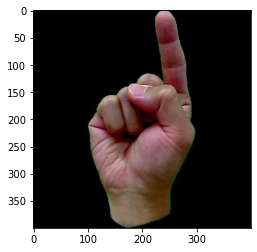

In [3]:
path = './asl_dataset/'
data,rawLabel = [],[]
labelTypes=[]
for root, dirs, files in os.walk(path):
    key = os.path.basename(root)
    if key=="": continue
    labelTypes.append(key)
    print(key, end=' ')
    for file in files:
        full_file_path = os.path.join(root,file)
        img = image.imread(full_file_path)
        data.append(img)
        rawLabel.append(key)

data = np.array(data)/255.0
rawLabel = np.array(rawLabel)
labelNum=len(labelTypes)
print(img.dtype,img.shape)
pyplot.imshow(img)
print(data.shape,rawLabel.shape,labelNum)
print(labelTypes)

In [4]:
label=np.array([[rawLabel[i]==labelTypes[j] for j in range(labelNum)]for i in range(len(rawLabel))]).astype('f4')
print(label.shape)
print(label[0])
print(label[-1])

(2515, 36)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
#split data into train and test for cross validation
X_train,X_use,y_train,y_use  = model_selection.train_test_split(data, label, train_size=0.8, shuffle=True)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_use, y_use, train_size=0.5, shuffle=True)
print(X_train.shape, X_test.shape,X_val.shape, y_train.shape, y_test.shape,y_val.shape)

(2012, 400, 400, 3) (251, 400, 400, 3) (252, 400, 400, 3) (2012, 36) (251, 36) (252, 36)


Data Analysis:

By observing the following histgram, 

we find that each type of images are almost the same amount(70).

By looking through each data type folder, 

we find that the qulities of each type of data is presistent.

(array([70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 65., 70., 70., 70., 70., 70., 70.]),
 array([ 0.        ,  0.97222222,  1.94444444,  2.91666667,  3.88888889,
         4.86111111,  5.83333333,  6.80555556,  7.77777778,  8.75      ,
         9.72222222, 10.69444444, 11.66666667, 12.63888889, 13.61111111,
        14.58333333, 15.55555556, 16.52777778, 17.5       , 18.47222222,
        19.44444444, 20.41666667, 21.38888889, 22.36111111, 23.33333333,
        24.30555556, 25.27777778, 26.25      , 27.22222222, 28.19444444,
        29.16666667, 30.13888889, 31.11111111, 32.08333333, 33.05555556,
        34.02777778, 35.        ]),
 <BarContainer object of 36 artists>)

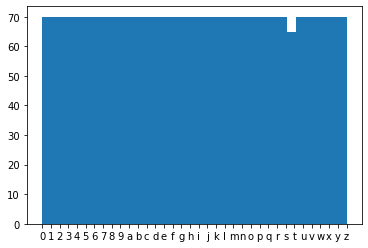

In [6]:
pyplot.hist(rawLabel,bins=labelNum)

AutoEncoder

In [7]:
class AutoEncoder(keras.Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.Conv2D(1, (5,5), strides=(5, 5), padding='same'),
      layers.Conv2D(8, (3,3), activation = 'relu',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(1, (3,3), activation = 'sigmoid',strides=1,padding='same')])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder=AutoEncoder()

In [8]:
X_trainTensor=tf.constant(X_train)
X_testTensor=tf.constant(X_test)
X_valTensor=tf.constant(X_val)
print(X_trainTensor.shape)

(2012, 400, 400, 3)


In [9]:
autoencoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history = autoencoder.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Epoch 1/40
63/63 [==============================] - 83s 1s/step - loss: 0.1004 - val_loss: 0.0596
Epoch 2/40
63/63 [==============================] - 84s 1s/step - loss: 0.0495 - val_loss: 0.0300
Epoch 3/40
63/63 [==============================] - 82s 1s/step - loss: 0.0169 - val_loss: 0.0115
Epoch 4/40
63/63 [==============================] - 82s 1s/step - loss: 0.0107 - val_loss: 0.0098
Epoch 5/40
63/63 [==============================] - 82s 1s/step - loss: 0.0094 - val_loss: 0.0089
Epoch 6/40
63/63 [==============================] - 82s 1s/step - loss: 0.0086 - val_loss: 0.0081
Epoch 7/40
63/63 [==============================] - 82s 1s/step - loss: 0.0079 - val_loss: 0.0075
Epoch 8/40
63/63 [==============================] - 82s 1s/step - loss: 0.0072 - val_loss: 0.0068
Epoch 9/40
63/63 [==============================] - 82s 1s/step - loss: 0.0065 - val_loss: 0.0062
Epoch 10/40
63/63 [==============================] - 82s 1s/step - loss: 0.0059 - val_loss: 0.0055
Epoch 11/40
63/63 [

In [10]:
autoencoder.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 40, 40, 1)         229       
                                                                 
 sequential_1 (Sequential)   (None, 400, 400, 3)       2941      
                                                                 
Total params: 3,170
Trainable params: 3,170
Non-trainable params: 0
_________________________________________________________________


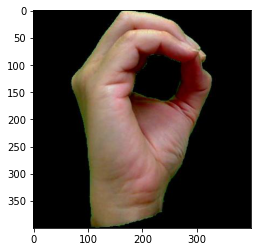

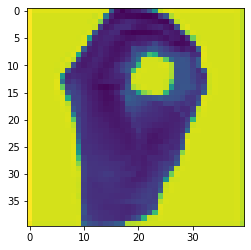

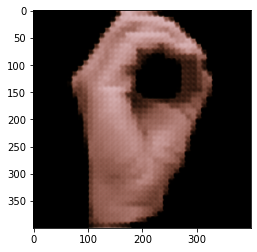

In [11]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=autoencoder.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [120]:
class AutoEncoder2(keras.Model):
  def __init__(self):
    super(AutoEncoder2, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(5, 5),strides=(5, 5), padding='same'),
      layers.Conv2D(8, (3,3), activation = 'relu',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(1, (3,3), activation = 'sigmoid',strides=1,padding='same')
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder2=AutoEncoder2()

In [121]:
autoencoder2.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history = autoencoder2.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Epoch 1/30


63/63 [==============================] - 112s 2s/step - loss: 0.1055 - val_loss: 0.0608
Epoch 2/30
60/63 [===========================>..] - ETA: 5s - loss: 0.0546

KeyboardInterrupt: 

In [14]:
autoencoder2.summary()

Model: "auto_encoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 40, 40, 1)         297       
                                                                 
 sequential_3 (Sequential)   (None, 400, 400, 3)       2941      
                                                                 
Total params: 3,238
Trainable params: 3,238
Non-trainable params: 0
_________________________________________________________________


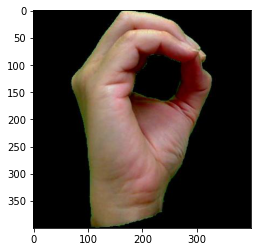

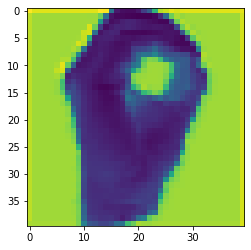

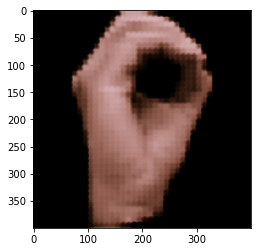

In [15]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder2.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=autoencoder2.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [16]:
class AutoEncoder3(keras.Model):
  def __init__(self):
    super(AutoEncoder3, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(10, 10),strides=(10, 10), padding='same'),
      layers.Conv2D(8, (3,3),strides=1,activation='relu', padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(1, (3,3),strides=1,activation="relu",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.BatchNormalization()
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(4,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(32,(3,3),strides=1,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.BatchNormalization()
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder3=AutoEncoder3()

In [17]:
autoencoder3.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history = autoencoder3.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Epoch 1/40
63/63 [==============================] - 100s 2s/step - loss: 0.1151 - val_loss: 0.0625
Epoch 2/40
63/63 [==============================] - 99s 2s/step - loss: 0.0599 - val_loss: 0.0541
Epoch 3/40
63/63 [==============================] - 99s 2s/step - loss: 0.0407 - val_loss: 0.0297
Epoch 4/40
63/63 [==============================] - 99s 2s/step - loss: 0.0281 - val_loss: 0.0271
Epoch 5/40
63/63 [==============================] - 99s 2s/step - loss: 0.0265 - val_loss: 0.0257
Epoch 6/40
63/63 [==============================] - 98s 2s/step - loss: 0.0257 - val_loss: 0.0251
Epoch 7/40
63/63 [==============================] - 98s 2s/step - loss: 0.0252 - val_loss: 0.0247
Epoch 8/40
63/63 [==============================] - 98s 2s/step - loss: 0.0247 - val_loss: 0.0244
Epoch 9/40
63/63 [==============================] - 97s 2s/step - loss: 0.0244 - val_loss: 0.0240
Epoch 10/40
63/63 [==============================] - 97s 2s/step - loss: 0.0242 - val_loss: 0.0238
Epoch 11/40
63/63 

In [18]:
autoencoder3.summary()

Model: "auto_encoder3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 10, 10, 1)         297       
                                                                 
 sequential_5 (Sequential)   (None, 400, 400, 3)       4285      
                                                                 
Total params: 4,582
Trainable params: 4,582
Non-trainable params: 0
_________________________________________________________________


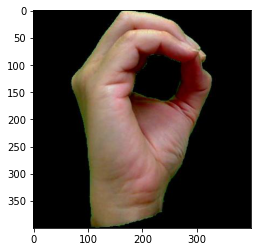

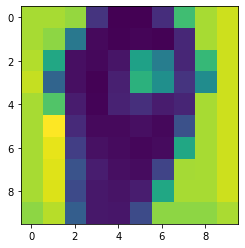

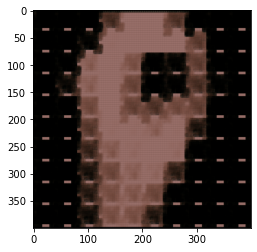

In [19]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder3.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy());
pyplot.show()
newImage=autoencoder3.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [116]:
class AutoEncoder4(keras.Model):
  def __init__(self):
    super(AutoEncoder4, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(10, 10),strides=(10, 10), padding='same'),
      layers.Conv2D(8, (3,3),strides=1,activation='relu', padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(2, (3,3),strides=1,activation="relu",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(1, (3,3),strides=1,activation="relu",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.BatchNormalization(),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(1,(5,5),strides=5,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(4,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(4,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(32,(3,3),strides=1,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder4=AutoEncoder4()

In [117]:
autoencoder4.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history = autoencoder4.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Epoch 1/30
63/63 [==============================] - 224s 4s/step - loss: 0.1000 - val_loss: 0.0646
Epoch 2/30
63/63 [==============================] - 290s 5s/step - loss: 0.0640 - val_loss: 0.0633
Epoch 3/30
63/63 [==============================] - 288s 5s/step - loss: 0.0525 - val_loss: 0.0650
Epoch 4/30
63/63 [==============================] - 287s 5s/step - loss: 0.0461 - val_loss: 0.0662
Epoch 5/30
63/63 [==============================] - 287s 5s/step - loss: 0.0448 - val_loss: 0.0609
Epoch 6/30
63/63 [==============================] - 283s 4s/step - loss: 0.0445 - val_loss: 0.0482
Epoch 7/30
63/63 [==============================] - 283s 5s/step - loss: 0.0404 - val_loss: 0.0472
Epoch 8/30
63/63 [==============================] - 283s 5s/step - loss: 0.0382 - val_loss: 0.0433
Epoch 9/30
63/63 [==============================] - 282s 4s/step - loss: 0.0368 - val_loss: 0.0412
Epoch 10/30
63/63 [==============================] - 282s 4s/step - loss: 0.0364 - val_loss: 0.0387
Epoch 11/

KeyboardInterrupt: 

In [112]:
class Clasiffier1(keras.Model):
  def __init__(self):
    super(Clasiffier1, self).__init__()
    self.linear = tf.keras.models.Sequential([
        layers.Conv2D(16, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(3, 3),strides=(3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(3, 3),strides=(3, 3), padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

  def call(self, x):
    encoded = autoencoder.encoder(x)
    return self.linear(encoded)
  
clasiffier1=Clasiffier1()

class Clasiffier2(keras.Model):
  def __init__(self):
    super(Clasiffier2, self).__init__()
    self.linear = tf.keras.models.Sequential([
        layers.Conv2D(16, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(3, 3),strides=(3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(3, 3),strides=(3, 3), padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

  def call(self, x):
    encoded = autoencoder2.encoder(x)
    return self.linear(encoded)
  
clasiffier2=Clasiffier2()

class Clasiffier3(keras.Model):
  def __init__(self):
    super(Clasiffier3, self).__init__()
    self.linear = tf.keras.models.Sequential([
        layers.Conv2D(32, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

  def call(self, x):
    encoded = autoencoder3.encoder(x)
    return self.linear(encoded)
  
clasiffier3=Clasiffier3()

In [21]:
Y_trainTensor=tf.constant(y_train)
Y_testTensor=tf.constant(y_test)
Y_valTensor=tf.constant(y_val)
print(Y_trainTensor.shape)

(2012, 36)


In [113]:
clasiffier1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = clasiffier1.fit(X_trainTensor, Y_trainTensor, epochs=100,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Epoch 1/100
63/63 [==============================] - 3s 42ms/step - loss: 1.1602 - accuracy: 0.6864 - val_loss: 3.3668 - val_accuracy: 0.1944
Epoch 2/100
63/63 [==============================] - 2s 32ms/step - loss: 0.2841 - accuracy: 0.9279 - val_loss: 3.7044 - val_accuracy: 0.1071
Epoch 3/100
63/63 [==============================] - 2s 30ms/step - loss: 0.1464 - accuracy: 0.9677 - val_loss: 4.0474 - val_accuracy: 0.1429
Epoch 4/100
63/63 [==============================] - 2s 30ms/step - loss: 0.0966 - accuracy: 0.9816 - val_loss: 4.0139 - val_accuracy: 0.1905
Epoch 5/100
63/63 [==============================] - 2s 30ms/step - loss: 0.0588 - accuracy: 0.9940 - val_loss: 3.5789 - val_accuracy: 0.2421
Epoch 6/100
63/63 [==============================] - 2s 29ms/step - loss: 0.0397 - accuracy: 0.9980 - val_loss: 2.5965 - val_accuracy: 0.3413
Epoch 7/100
63/63 [==============================] - 2s 30ms/step - loss: 0.0328 - accuracy: 0.9970 - val_loss: 1.5343 - val_accuracy: 0.5397
Epoch 

KeyboardInterrupt: 

In [ ]:
clasiffier1.summary()

In [100]:
clasiffier2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = clasiffier2.fit(X_trainTensor, Y_trainTensor, epochs=200,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Epoch 1/200
63/63 [==============================] - 3s 37ms/step - loss: 1.2079 - accuracy: 0.6670 - val_loss: 3.5734 - val_accuracy: 0.0357
Epoch 2/200
63/63 [==============================] - 2s 35ms/step - loss: 0.2945 - accuracy: 0.9220 - val_loss: 4.2549 - val_accuracy: 0.0357
Epoch 3/200
63/63 [==============================] - 2s 35ms/step - loss: 0.1514 - accuracy: 0.9732 - val_loss: 5.5409 - val_accuracy: 0.0357
Epoch 4/200
63/63 [==============================] - 2s 34ms/step - loss: 0.0983 - accuracy: 0.9851 - val_loss: 5.9484 - val_accuracy: 0.0357
Epoch 5/200
63/63 [==============================] - 2s 35ms/step - loss: 0.0650 - accuracy: 0.9916 - val_loss: 5.9037 - val_accuracy: 0.0357
Epoch 6/200
63/63 [==============================] - 2s 35ms/step - loss: 0.0429 - accuracy: 0.9970 - val_loss: 5.2125 - val_accuracy: 0.0635
Epoch 7/200
63/63 [==============================] - 2s 35ms/step - loss: 0.0367 - accuracy: 0.9965 - val_loss: 3.2390 - val_accuracy: 0.2579
Epoch 

KeyboardInterrupt: 

In [23]:
clasiffier2.summary()

Model: "clasiffier2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 36)                209572    
                                                                 
Total params: 209,572
Trainable params: 209,572
Non-trainable params: 0
_________________________________________________________________


In [109]:
clasiffier3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = clasiffier3.fit(X_trainTensor, Y_trainTensor, epochs=200,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)
clasiffier3.summary()

Epoch 1/200
63/63 [==============================] - 3s 37ms/step - loss: 0.9590 - accuracy: 0.7291 - val_loss: 3.5167 - val_accuracy: 0.1587
Epoch 2/200
63/63 [==============================] - 2s 36ms/step - loss: 0.3073 - accuracy: 0.9046 - val_loss: 3.6208 - val_accuracy: 0.1389
Epoch 3/200
63/63 [==============================] - 2s 31ms/step - loss: 0.1749 - accuracy: 0.9533 - val_loss: 3.6921 - val_accuracy: 0.1429
Epoch 4/200
63/63 [==============================] - 2s 28ms/step - loss: 0.1214 - accuracy: 0.9697 - val_loss: 3.7100 - val_accuracy: 0.1786
Epoch 5/200
63/63 [==============================] - 2s 27ms/step - loss: 0.0970 - accuracy: 0.9722 - val_loss: 3.2271 - val_accuracy: 0.2579
Epoch 6/200
63/63 [==============================] - 2s 27ms/step - loss: 0.0817 - accuracy: 0.9811 - val_loss: 2.6743 - val_accuracy: 0.3214
Epoch 7/200
63/63 [==============================] - 2s 27ms/step - loss: 0.0483 - accuracy: 0.9881 - val_loss: 1.8837 - val_accuracy: 0.4722
Epoch 

KeyboardInterrupt: 